In [1]:
include("../src/Hydro.jl");

In [2]:
using .Hydro
using CSV
using DataFrames
using Printf: @sprintf

# Load some data

In [3]:
# load a test dataset from a CSV file into a dataframe
df = CSV.read("../test/data/test_2_data.csv", header=1, missingstrings=["-9999"]);

In [4]:
size(df)

(12417, 5)

In [5]:
len = @sprintf("%.1f", size(df)[1] / 365)
println("Period of record is $len years")

Period of record is 34.0 years


In [6]:
names(df)

5-element Array{Symbol,1}:
 :date            
 :obs_rain        
 :obs_pet         
 :obs_runoff      
 :obs_runoff_sim_0

In [7]:
# rename the columns
names!(df, Symbol.(["date", "obs_rain", "obs_pet", "obs_runoff", "test_sim_runoff"]));

In [8]:
# Create a dictionary of data from the dataframe - standard data structure through Hydro
data = Dict()
data[:rain] = df[:obs_rain]
data[:pet] = df[:obs_pet]
data[:runoff_obs] = df[:obs_runoff]
data[:runoff_sim_test] = df[:test_sim_runoff];

# Calibrate GR4J parameters

- GR4J model with NSE objective function (minimised so -ve)
- Differential evolution optimiser with adaptive weights over a limited radius
- Take best parameter set after 5 minutes
- Display best sample every 15 seconds

Available methods: https://github.com/robertfeldt/BlackBoxOptim.jl#existing-optimizers

In [9]:
# build up dictionary of model functions needed for calibration
functions = Dict()
functions[:run_model_time_step] = gr4j_run_step
functions[:init_state] = gr4j_init_state
functions[:params_from_array] = gr4j_params_from_array
functions[:objective_function] = (obs, sim) -> -1 * nse(obs, sim)
functions[:params_inverse_transform] = gr4j_params_trans_inv
functions[:params_range_transform] = gr4j_params_range_trans
functions[:params_range_to_tuples] = gr4j_params_range_to_tuples

gr4j_params_range_to_tuples (generic function with 1 method)

In [10]:
# build up dictionary of optimiser options needed for calibration
opt_options = Dict()
opt_options[:max_iterations] = false
opt_options[:max_time] = 5 * 60
opt_options[:trace_interval] = 15
opt_options[:method] = :adaptive_de_rand_1_bin_radiuslimited

:adaptive_de_rand_1_bin_radiuslimited

In [11]:
opt_pars, opt_nse = calibrate(functions, opt_options, data, gr4j_params_range())
opt_nse *= -1

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
15.14 secs, 81 evals, 46 steps, improv/step: 0.609 (last = 0.6087), fitness=-0.677184210
30.20 secs, 163 evals, 103 steps, improv/step: 0.388 (last = 0.2105), fitness=-0.677184210
45.38 secs, 245 evals, 167 steps, improv/step: 0.365 (last = 0.3281), fitness=-0.677184210
60.47 secs, 326 evals, 235 steps, improv/step: 0.353 (last = 0.3235), fitness=-0.705793520
75.55 secs, 405 evals, 308 steps, improv/step: 0.321 (last = 0.2192), fitness=-0.705793520
90.61 secs, 485 evals, 384 steps, improv/step: 0.297 (last = 0.1974), fitness=-0.757828228
105.76 secs, 566 evals, 461 steps, improv/step: 0.299 (last = 0.3117), fitness=-0.757828228
120.82 secs, 647 evals, 541 steps, improv/step: 0.288 (last = 0.2250), fitness=-0.757828228
135.

0.8324560097493926

In [12]:
opt_pars

Dict{Symbol,Float64} with 4 entries:
  :x2 => 0.751911
  :x3 => 232.321
  :x4 => 1.45667
  :x1 => 44.054

In [13]:
# test parameters were
gr4j_params_from_array(CSV.read("../test/data/test_2_params.csv", delim=":", header=0)[2])

Dict{Symbol,Float64} with 4 entries:
  :x2 => -0.039867
  :x3 => 249.783
  :x4 => 1.49495
  :x1 => 55.0616

# Simulate using these calibrated parameters

In [14]:
init_state = gr4j_init_state(opt_pars)

Dict{Symbol,Any} with 6 entries:
  :uh2_ordinates    => [0.195239, 0.649111, 0.155651, 0.0]
  :uh1_ordinates    => [0.390477, 0.609523]
  :uh2              => [0.0, 0.0, 0.0, 0.0]
  :production_store => 0
  :routing_store    => 0
  :uh1              => [0.0, 0.0]

In [15]:
sim = simulate(gr4j_run_step, data, opt_pars, init_state);
data[:runoff_sim_gr4j] = sim;

In [16]:
keys(data)

Base.KeySet for a Dict{Any,Any} with 5 entries. Keys:
  :rain
  :pet
  :runoff_obs
  :runoff_sim_test
  :runoff_sim_gr4j

# Do same for simple OSTP educational model
One store and two parameters

Just search for 1 minute, searching for longer wont find a magic parameter set that makes this a good model!

In [17]:
# build up dictionary of model functions needed for calibration
functions = Dict()
functions[:run_model_time_step] = ostp_run_step
functions[:init_state] = ostp_init_state
functions[:params_from_array] = ostp_params_from_array
functions[:objective_function] = (obs, sim) -> -1 * nse(obs, sim)
functions[:params_range_to_tuples] = ostp_params_range_to_tuples

# build up dictionary of optimiser options needed for calibration
opt_options = Dict()
opt_options[:max_iterations] = false
opt_options[:max_time] = 1 * 60
opt_options[:trace_interval] = 15
opt_options[:method] = :adaptive_de_rand_1_bin_radiuslimited

opt_pars, opt_nse = calibrate(functions, opt_options, data, ostp_params_range())
opt_nse *= -1

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
15.00 secs, 2159 evals, 2051 steps, improv/step: 0.340 (last = 0.3403), fitness=-0.286333436
30.01 secs, 4305 evals, 4199 steps, improv/step: 0.301 (last = 0.2626), fitness=-0.286334992
45.01 secs, 6359 evals, 6253 steps, improv/step: 0.294 (last = 0.2819), fitness=-0.286334992

Optimization stopped after 8404 steps and 60.00208592414856 seconds
Termination reason: Max time (60.0 s) reached
Steps per second = 140.06179736190987
Function evals per second = 141.79507043730715
Improvements/step = Inf
Total function evaluations = 8508


Best candidate found: [17.7228, 20.4871]

Fitness: -0.286334992



0.2863349917208353

In [18]:
opt_pars

Dict{Symbol,Float64} with 2 entries:
  :loss     => 20.4871
  :capacity => 17.7228

In [19]:
init_state = ostp_init_state(opt_pars)

8.861390966532495

In [20]:
sim = simulate(ostp_run_step, data, opt_pars, init_state);
data[:runoff_sim] = sim;

# Plot a hydrograph for a few months

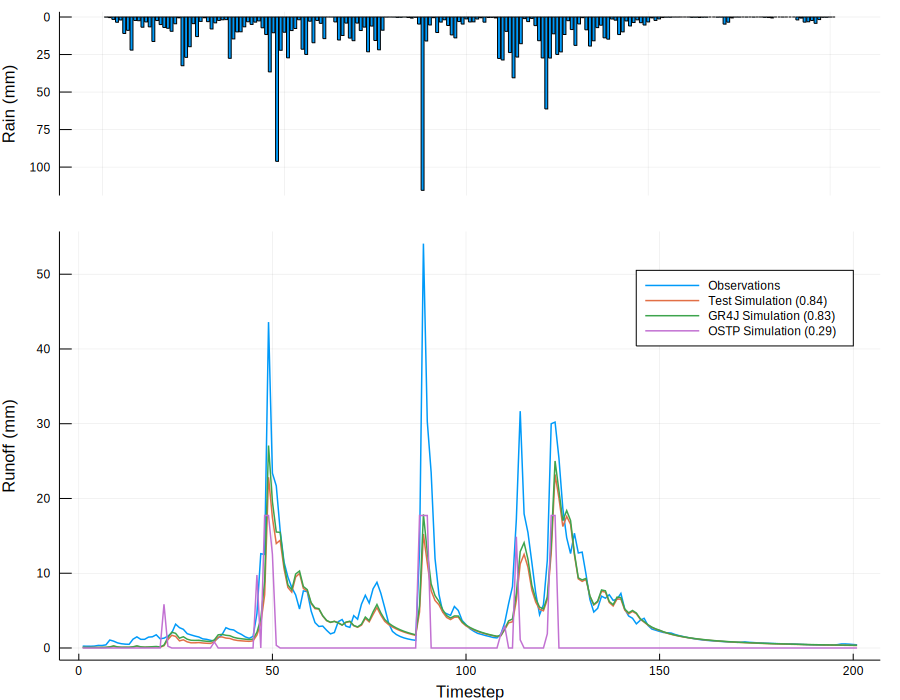

In [21]:
s, e = 12000, 12200

obs = data[:runoff_obs][s:e]
test = data[:runoff_sim_test][s:e]
gr4j = data[:runoff_sim_gr4j][s:e]
ostp = data[:runoff_sim][s:e]
rain = data[:rain][s:e]

nse_test = @sprintf("%.2f", nse(data[:runoff_obs], data[:runoff_sim_test]))
nse_gr4j = @sprintf("%.2f", nse(data[:runoff_obs], data[:runoff_sim_gr4j]))
nse_ostp = @sprintf("%.2f", nse(data[:runoff_obs], data[:runoff_sim]))

hydrograph(rain, [obs, test, gr4j, ostp], 
    ["Observations", "Test Simulation ($nse_test)", "GR4J Simulation ($nse_gr4j)", "OSTP Simulation ($nse_ostp)"])